=============================================================================

**CLOUD AND SKY-IMAGE BASED RAIN PREDICTION SYSTEM**

Final Project - Pengolahan Citra Digital dan Visi Komputer

=============================================================================

Kelompok: 9

**Anggota: <br>**
Silvana Arayunda Marbun - 235150201111076 <br>
Nicolas Gabriel Siahaan - 235150200111038 <br>


**3 Materi**
1. Segmentasi (Thresholding Otsu + Morphological Operations)
2. Feature Extraction (GLCM - Gray Level Co-occurrence Matrix)
3. Klasifikasi (SVM - Support Vector Machine)

============================================================================

PERSIAPAN & IMPOR LIBRARY

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os, cv2, random, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_recall_fscore_support
)
from skimage.feature import graycomatrix, graycoprops

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Direktori dataset & hasil
BASE_DIR = '/content/drive/MyDrive/FinalProject_PCDVK'
DATA_DIR = 'dataset/multiclass_weather_dataset'
DATASET_DIR = os.path.join(BASE_DIR, DATA_DIR)
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

IMG_SIZE = (256, 256)

Mounted at /content/drive/


SEGMENTASI (OTSU + MORPHOLOGY)

In [ ]:
class CloudSegmenter:
    def __init__(self, kernel_size=5):
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    def segment(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        # Morphology
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, self.kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, self.kernel)
        final_mask = cv2.dilate(closing, self.kernel, iterations=1)
        coverage = (np.sum(final_mask > 0) / final_mask.size) * 100
        return {
            'grayscale': gray,
            'binary': binary,
            'opening': opening,
            'closing': closing,
            'final_mask': final_mask,
            'coverage': coverage
        }

    def visualize(self, image, results, save_path=None):
        fig, axes = plt.subplots(2, 3, figsize=(15, 9))
        fig.suptitle('MATERI 1: SEGMENTASI (Otsu + Morphology)', fontsize=14, fontweight='bold')

        axes[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('Original'); axes[0,0].axis('off')

        axes[0,1].imshow(results['grayscale'], cmap='gray')
        axes[0,1].set_title('Grayscale'); axes[0,1].axis('off')

        axes[0,2].imshow(results['binary'], cmap='gray')
        axes[0,2].set_title('Otsu Thresholding'); axes[0,2].axis('off')

        axes[1,0].imshow(results['opening'], cmap='gray')
        axes[1,0].set_title('Opening (Remove Noise)'); axes[1,0].axis('off')

        axes[1,1].imshow(results['closing'], cmap='gray')
        axes[1,1].set_title('Closing (Fill Holes)'); axes[1,1].axis('off')

        axes[1,2].imshow(results['final_mask'], cmap='gray')
        axes[1,2].set_title(f'Final Mask\nCoverage: {results["coverage"]:.1f}%'); axes[1,2].axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

segmenter = CloudSegmenter()

FEATURE EXTRACTION (GLCM)

In [ ]:
class GLCMFeatureExtractor:
    def __init__(self):
        self.distances = [1]
        self.angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    def extract_features(self, image, mask=None):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        if mask is not None:
            gray = cv2.bitwise_and(gray, gray, mask=mask)

        glcm = graycomatrix(gray, self.distances, self.angles, levels=256, symmetric=True, normed=True)

        features = {
            'contrast': float(graycoprops(glcm, 'contrast')[0,0]),
            'dissimilarity': float(graycoprops(glcm, 'dissimilarity')[0,0]),
            'homogeneity': float(graycoprops(glcm, 'homogeneity')[0,0]),
            'energy': float(graycoprops(glcm, 'energy')[0,0]),
            'correlation': float(graycoprops(glcm, 'correlation')[0,0]),
            'ASM': float(graycoprops(glcm, 'ASM')[0,0])
        }

        pixels = gray[mask > 0] if mask is not None else gray.flatten()
        features.update({
            'mean_intensity': float(np.mean(pixels)),
            'std_intensity': float(np.std(pixels)),
            'min_intensity': int(np.min(pixels)),
            'max_intensity': int(np.max(pixels))
        })
        return features

    def visualize(self, image, features, save_path=None):
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        fig.suptitle('MATERI 2: FEATURE EXTRACTION (GLCM)', fontsize=14, fontweight='bold')

        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original'); axes[0].axis('off')

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        axes[1].imshow(gray, cmap='gray')
        axes[1].set_title('Grayscale for GLCM'); axes[1].axis('off')

        axes[2].axis('off')
        text = "GLCM FEATURES:\n" + "="*28 + "\n"
        for k, v in features.items():
            text += f"{k:15s}: {v:.3f}\n" if isinstance(v, float) else f"{k:15s}: {v}\n"
        axes[2].text(0.05, 0.5, text, fontsize=10, family='monospace', va='center')
        axes[2].set_title('Extracted Features')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

extractor = GLCMFeatureExtractor()


COLOUR EXTRACTION

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

class ColorFeatureExtractor:
    def __init__(self):
        pass

    def extract_features(self, image, mask=None):

        hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lab_img = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

        (B, G, R) = cv2.split(image.astype("float"))
        (H, S, V) = cv2.split(hsv_img.astype("float"))
        (L, a, b) = cv2.split(lab_img.astype("float"))

        if mask is not None:
            B = B[mask > 0]; G = G[mask > 0]; R = R[mask > 0]
            H = H[mask > 0]; S = S[mask > 0]; V = V[mask > 0]
            L = L[mask > 0]; a = a[mask > 0]; b = b[mask > 0]
        else:
            B = B.flatten(); G = G.flatten(); R = R.flatten()
            H = H.flatten(); S = S.flatten(); V = V.flatten()
            L = L.flatten(); a = a.flatten(); b = b.flatten()

        features = {}

        features['mean_R'] = np.mean(R)
        features['mean_G'] = np.mean(G)
        features['mean_B'] = np.mean(B)
        features['R_B_Ratio'] = np.mean(R) / (np.mean(B) + 1e-5)

        features['mean_H'] = np.mean(H)
        features['mean_S'] = np.mean(S)
        features['mean_V'] = np.mean(V)

        features['mean_L'] = np.mean(L)
        features['mean_a'] = np.mean(a)
        features['mean_b'] = np.mean(b) # High = Warm (Sunshine), Low = Cool (Shine)
        features['std_b']  = np.std(b)

        return features

    def visualize(self, image, features, save_path=None):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('MATERI 3: COLOR FEATURE EXTRACTION', fontsize=14, fontweight='bold')

        axes[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')

        colors = ('b', 'g', 'r')
        for i, col in enumerate(colors):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            axes[0,1].plot(hist, color=col)
            axes[0,1].set_xlim([0, 256])
        axes[0,1].set_title('RGB Color Histogram\n(Watch Red vs Blue peaks)')
        axes[0,1].grid(True, alpha=0.3)

        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
        l, a, b = cv2.split(lab_image)
        im_b = axes[1,0].imshow(b, cmap='jet')
        axes[1,0].set_title("Lab 'b' Channel Heatmap\n(Blue=Cool/Sky, Red=Warm/Sun)")
        axes[1,0].axis('off')
        plt.colorbar(im_b, ax=axes[1,0], fraction=0.046, pad=0.04)

        axes[1,1].axis('off')
        text = "EXTRACTED COLOR FEATURES:\n" + "="*30 + "\n"

        groups = [
            ("RGB & Ratios", ['mean_R', 'mean_B', 'R_B_Ratio']),
            ("HSV (Hue/Sat)", ['mean_H', 'mean_S', 'mean_V']),
            ("Lab (a/b axis)", ['mean_L', 'mean_a', 'mean_b'])
        ]

        for group_name, keys in groups:
            text += f"\n[{group_name}]\n"
            for k in keys:
                v = features.get(k, 0)
                text += f"{k:15s}: {v:.3f}\n"

        axes[1,1].text(0.05, 0.95, text, fontsize=10, family='monospace', va='top')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

color_extractor = ColorFeatureExtractor()

LOAD DATASET & TRAINING SVM

In [ ]:
def load_dataset(dataset_dir, max_per_cat=None):
    all_features, all_labels = [], []
    folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
    print(f"Found categories: {folders}")

    for folder in folders:
        folder_path = os.path.join(dataset_dir, folder)
        imgs = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        if max_per_cat is not None:
            imgs = imgs[:max_per_cat]
        print(f"> {folder}: {len(imgs)} images")
        for idx, fname in enumerate(imgs):
            img_path = os.path.join(folder_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Gagal membaca: {img_path}")
                continue
            img = cv2.resize(img, IMG_SIZE)
            seg_res = segmenter.segment(img)
            glcm_features = extractor.extract_features(img, seg_res['final_mask'])
            color_features = color_extractor.extract_features(img)
            combined_features = {**glcm_features, **color_features}
            all_features.append(combined_features)
            all_labels.append(folder)
            if (idx+1) % 25 == 0 or (idx+1) == len(imgs):
                print(f"  Progress {folder}: {idx+1}/{len(imgs)}")

    df = pd.DataFrame(all_features)
    df['label'] = all_labels

    print(f"\nFeature Extraction Complete.")
    print(f"Total Features per image: {df.shape[1] - 1}") # -1 to exclude label column
    return df

INISIASI DATAFRAME

In [ ]:
df = load_dataset(dataset_dir=DATASET_DIR)

Found categories: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
> Cloudy: 300 images
  Progress Cloudy: 25/300
  Progress Cloudy: 50/300
  Progress Cloudy: 75/300
  Progress Cloudy: 100/300
  Progress Cloudy: 125/300
  Progress Cloudy: 150/300
  Progress Cloudy: 175/300
  Progress Cloudy: 200/300
  Progress Cloudy: 225/300
  Progress Cloudy: 250/300
  Progress Cloudy: 275/300
  Progress Cloudy: 300/300
> Rain: 215 images
  Progress Rain: 25/215
  Progress Rain: 50/215
  Progress Rain: 75/215
  Progress Rain: 100/215
  Progress Rain: 125/215
  Progress Rain: 150/215
  Progress Rain: 175/215
  Progress Rain: 200/215
  Progress Rain: 215/215
> Shine: 253 images
  Progress Shine: 25/253
  Progress Shine: 50/253
  Progress Shine: 75/253
  Progress Shine: 100/253
  Progress Shine: 125/253
  Progress Shine: 150/253
  Progress Shine: 175/253
  Progress Shine: 200/253
  Progress Shine: 225/253
  Progress Shine: 250/253
  Progress Shine: 253/253
> Sunrise: 357 images
  Progress Sunrise: 25/357
  Progre

In [ ]:
pd.set_option('display.max_columns', None)

df.head()

contrast  dissimilarity  homogeneity    energy  correlation       ASM  \
0  163.184360       2.021890     0.754607  0.360041     0.948851  0.129629   
1  495.043873       5.730086     0.599707  0.368288     0.894037  0.135636   
2  189.418658       2.261949     0.801360  0.519929     0.941381  0.270327   
3  251.026547       4.188741     0.697957  0.646620     0.948181  0.418117   
4  212.616360       2.901593     0.653525  0.427698     0.943301  0.182926   

   mean_intensity  std_intensity  min_intensity  max_intensity      mean_R  \
0       69.488382      27.433006             16            192  102.807617   
1       79.680576      36.796233              8            227   97.005142   
2       70.026921      28.745498              0            208  103.118866   
3       97.877655      26.626346             11            209  141.044067   
4       77.543658      26.450190             24            204  106.903122   

       mean_G      mean_B  R_B_Ratio      mean_H      mean_S      mean_V  \
0  102.807617  102.807617   1.000000    0.000000    0.000000  102.807617   
1  124.637405  159.378571   0.608646  105.973785  118.445877  159.378677   
2  110.105148  128.113449   0.804903  111.663513   56.040802  128.123886   
3  141.193329  129.312363   1.090724   74.948441   75.076950  154.243378   
4  114.590790  128.228394   0.833693  106.051956   53.453491  128.883286   

       mean_L      mean_a      mean_b      std_b   label  
0  108.576401  128.000000  128.000000   0.000000  Cloudy  
1  129.419952  129.674347  105.786530  11.962384  Cloudy  
2  116.732101  129.727234  117.152130   6.269184  Cloudy  
3  148.647491  127.246262  134.730438  22.220245  Cloudy  
4  120.759613  128.432083  119.336441   4.830243  Cloudy

VISUALISASI DISTRIBUSI FITUR

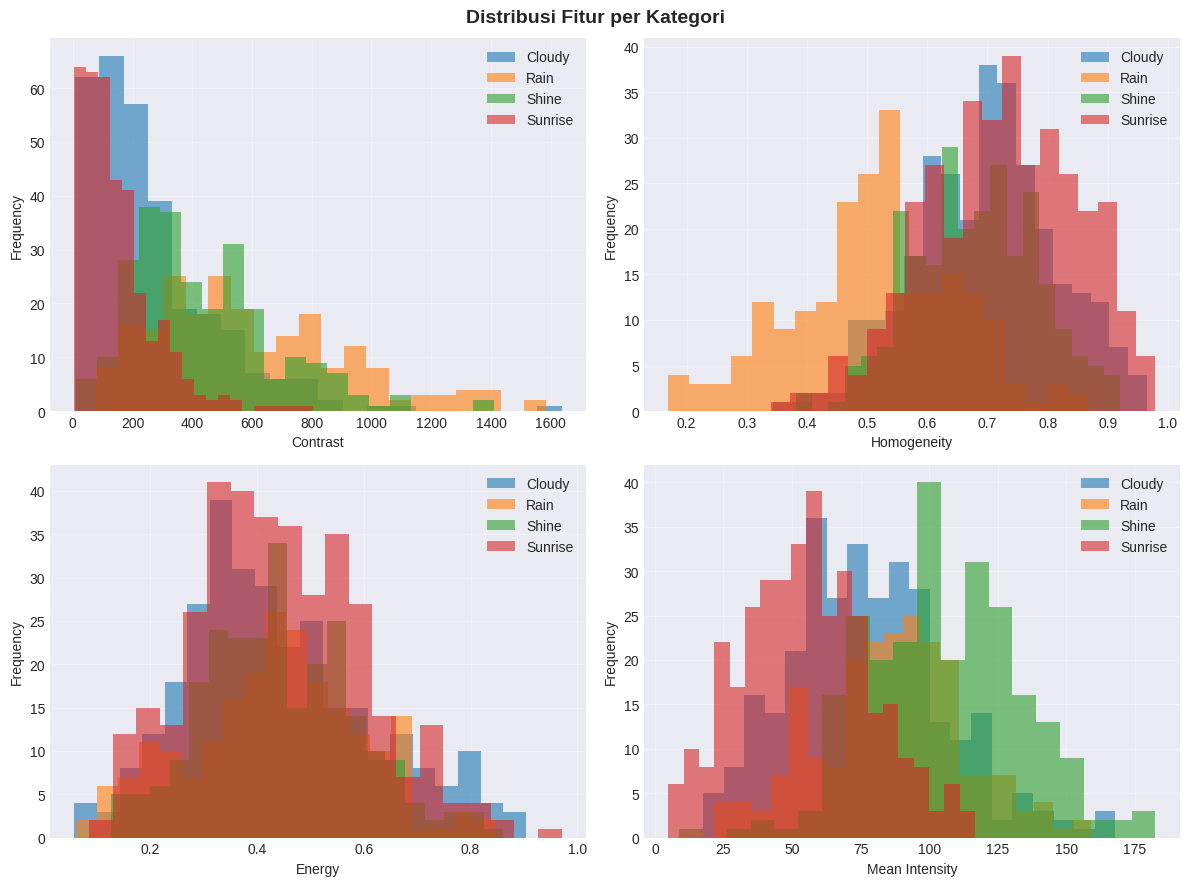

In [ ]:
# =========================================
# VISUALISASI DISTRIBUSI FITUR
# =========================================
categories = sorted(df['label'].unique().tolist())
main_features = ['contrast', 'homogeneity', 'energy', 'mean_intensity']

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle('Distribusi Fitur per Kategori', fontsize=14, fontweight='bold')

for idx, feat in enumerate(main_features):
    ax = axes[idx//2, idx%2]
    for cat in categories:
        data = df[df['label'] == cat][feat]
        ax.hist(data, bins=20, alpha=0.6, label=cat.capitalize())
    ax.set_xlabel(feat.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'feature_distribution.png'), dpi=150)
plt.show()

TRAINING + EVALUASI MODEL (VISUAL)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Accuracy: 96.78%
Testing Accuracy:  88.89%
Overfitting gap:  7.89%

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.86      0.83      0.85        60
        Rain       0.93      0.91      0.92        43
       Shine       0.83      0.86      0.85        51
     Sunrise       0.93      0.94      0.94        71

    accuracy                           0.89       225
   macro avg       0.89      0.89      0.89       225
weighted avg       0.89      0.89      0.89       225



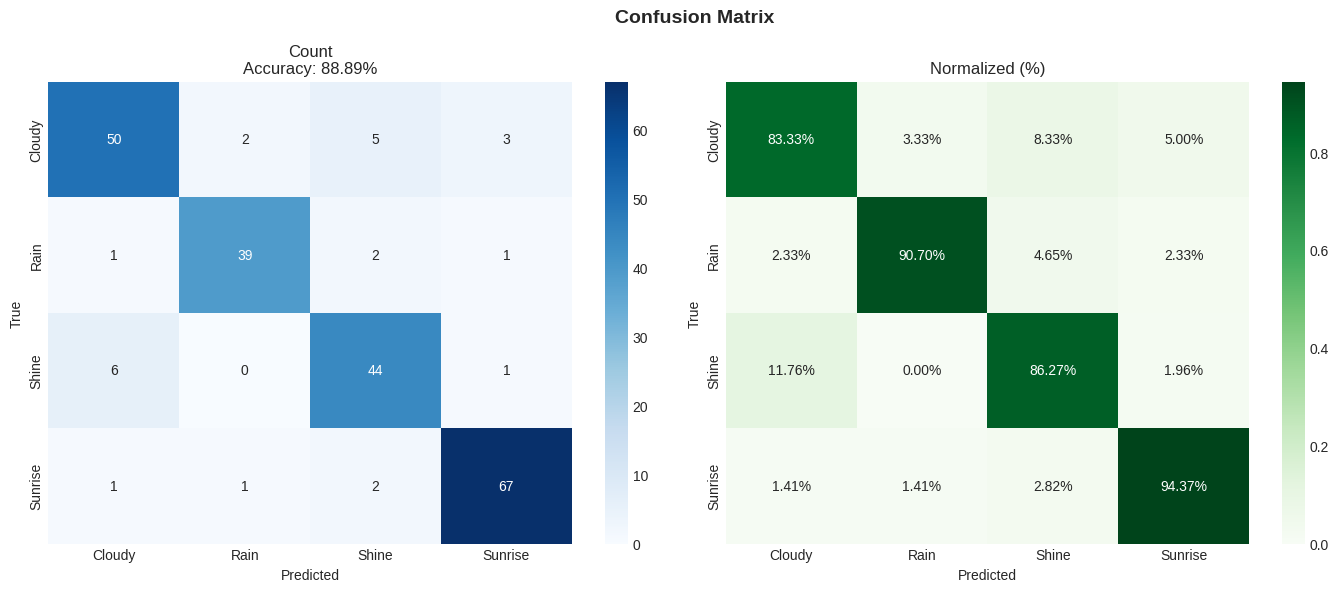

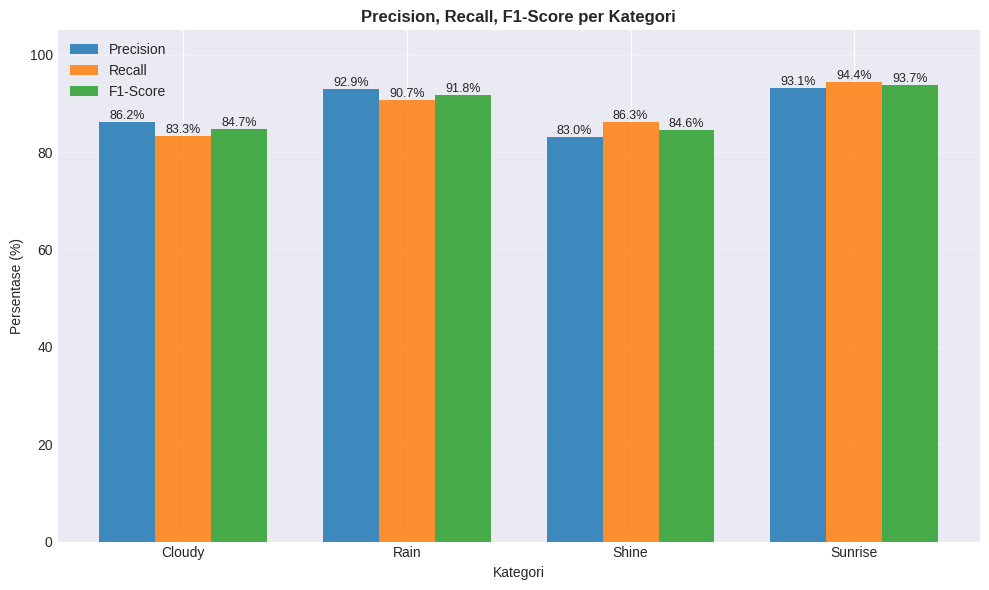

In [ ]:
X = df.drop('label', axis=1)
y = df['label']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

param_grid = {'C':[1,10,100], 'gamma':[0.001,0.01,0.1], 'kernel':['rbf']}
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train_sc, y_train)

svm = SVC(**grid.best_params_, random_state=42, probability=True)
svm.fit(X_train_sc, y_train)

y_train_pred = svm.predict(X_train_sc)
y_test_pred = svm.predict(X_test_sc)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
overfit_gap = abs(train_acc - test_acc) * 100

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy:  {test_acc*100:.2f}%")
print(f"Overfitting gap:  {overfit_gap:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Confusion Matrix (count + normalized)
cm = confusion_matrix(y_test, y_test_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Confusion Matrix', fontsize=14, fontweight='bold')

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'Count\nAccuracy: {test_acc*100:.2f}%')
axes[0].set_ylabel('True'); axes[0].set_xlabel('Predicted')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('Normalized (%)')
axes[1].set_ylabel('True'); axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

# Precision, Recall, F1 per kategori
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred, average=None)
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(le.classes_)); width = 0.25

bars1 = ax.bar(x - width, precision*100, width, label='Precision', alpha=0.85)
bars2 = ax.bar(x,         recall*100,    width, label='Recall',    alpha=0.85)
bars3 = ax.bar(x + width, f1*100,        width, label='F1-Score',  alpha=0.85)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2., h, f'{h:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Kategori'); ax.set_ylabel('Persentase (%)')
ax.set_title('Precision, Recall, F1-Score per Kategori', fontsize=12, fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels([c.capitalize() for c in le.classes_])
ax.legend(); ax.grid(True, alpha=0.3, axis='y'); ax.set_ylim([0, 105])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'metrics_comparison.png'), dpi=150)
plt.show()


SIMPAN MODEL

In [ ]:
with open(os.path.join(MODELS_DIR,'svm_model.pkl'),'wb') as f:
    pickle.dump(svm,f)
with open(os.path.join(MODELS_DIR,'scaler.pkl'),'wb') as f:
    pickle.dump(scaler,f)
with open(os.path.join(MODELS_DIR,'label_encoder.pkl'),'wb') as f:
    pickle.dump(le,f)

print("✅ Model, Scaler, dan Encoder berhasil disimpan.")


✅ Model, Scaler, dan Encoder berhasil disimpan.


PREDIKSI GAMBAR BARU

In [ ]:
def predict_image_with_visual(image_path, show_panels=True, save_prefix='predict_'):
    with open(os.path.join(MODELS_DIR,'svm_model.pkl'),'rb') as f: model = pickle.load(f)
    with open(os.path.join(MODELS_DIR,'scaler.pkl'),'rb') as f: scaler = pickle.load(f)
    with open(os.path.join(MODELS_DIR,'label_encoder.pkl'),'rb') as f: enc = pickle.load(f)

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Gambar tidak ditemukan: {image_path}")
    img = cv2.resize(img, IMG_SIZE)

    seg_res = segmenter.segment(img)
    glcm_features = extractor.extract_features(img, seg_res['final_mask'])
    color_features = color_extractor.extract_features(img)
    features = {**glcm_features, **color_features} # Combine both feature sets

    feat_df = pd.DataFrame([features])
    feat_scaled = scaler.transform(feat_df)

    pred = model.predict(feat_scaled)
    label = enc.inverse_transform(pred)[0]
    prob = model.predict_proba(feat_scaled)[0]
    classes = enc.classes_
    top_idx = np.argsort(prob)[::-1][:2]
    prob_text = "\nProbabilitas (Top-2):\n" + "\n".join([f"- {classes[i]}: {prob[i]*100:.1f}%" for i in top_idx])

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediksi: {label}\nCloud Coverage: {seg_res['coverage']:.2f}%\n{prob_text}", fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.savefig(os.path.join(RESULTS_DIR, f'{save_prefix}prediction.png'), dpi=150, bbox_inches='tight')
    plt.show()

    if show_panels:
        segmenter.visualize(img, seg_res, save_path=os.path.join(RESULTS_DIR, f'{save_prefix}segmentation.png'))
        extractor.visualize(img, glcm_features, save_path=os.path.join(RESULTS_DIR, f'{save_prefix}features.png'))
        color_extractor.visualize(img, color_features, save_path=os.path.join(RESULTS_DIR, f'{save_prefix}color_features.png'))

    return label, features


UPLOAD & ANALISIS

In [ ]:
from google.colab import files
uploaded = files.upload()  # pilih file foto awan dari device

for fn in uploaded.keys():
    test_image_path = fn
    print("✅ Gambar berhasil diupload:", test_image_path)

label_pred, feat_pred = predict_image_with_visual(
    test_image_path,
    show_panels=True,
    save_prefix='custom_'
)

print("Label Prediksi:", label_pred)
print("Fitur (ringkas):", {k: round(v, 3) if isinstance(v, float) else v for k,v in feat_pred.items()})


BATCH TESTING

[1] Menggunakan gambar: Shine/shine213.jpg


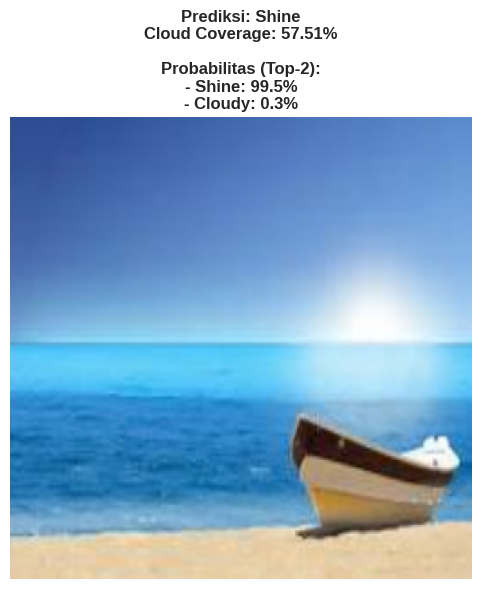

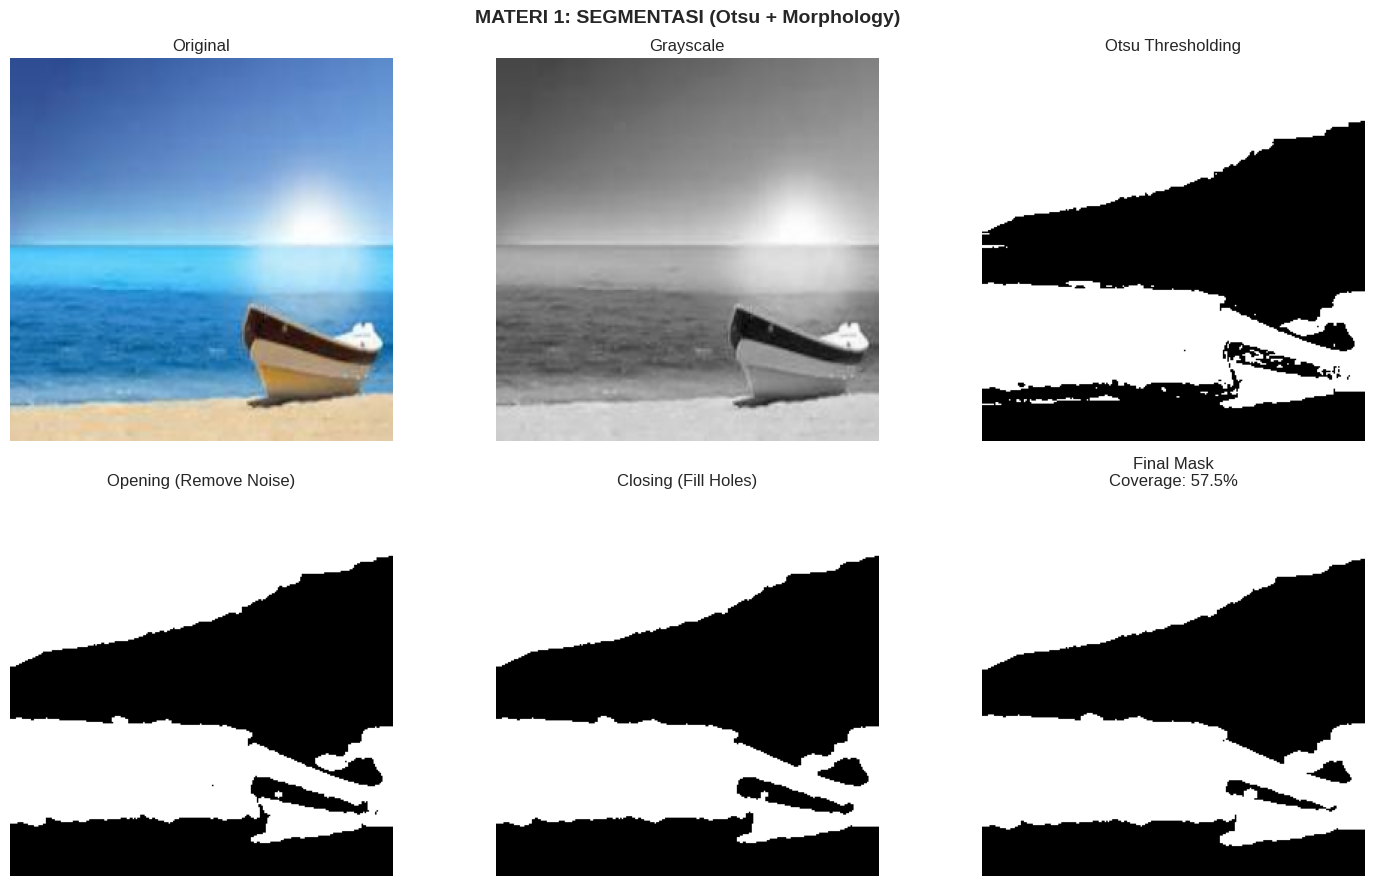

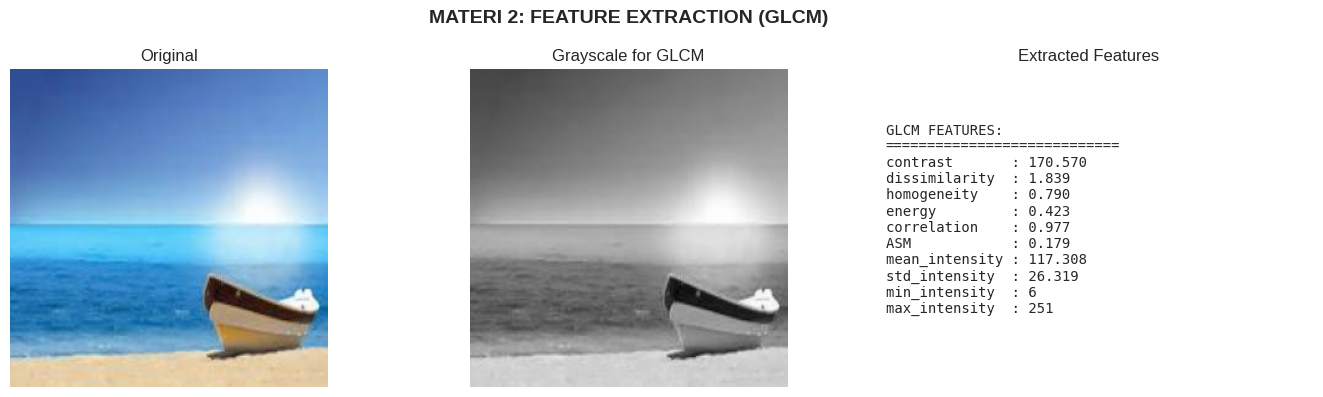

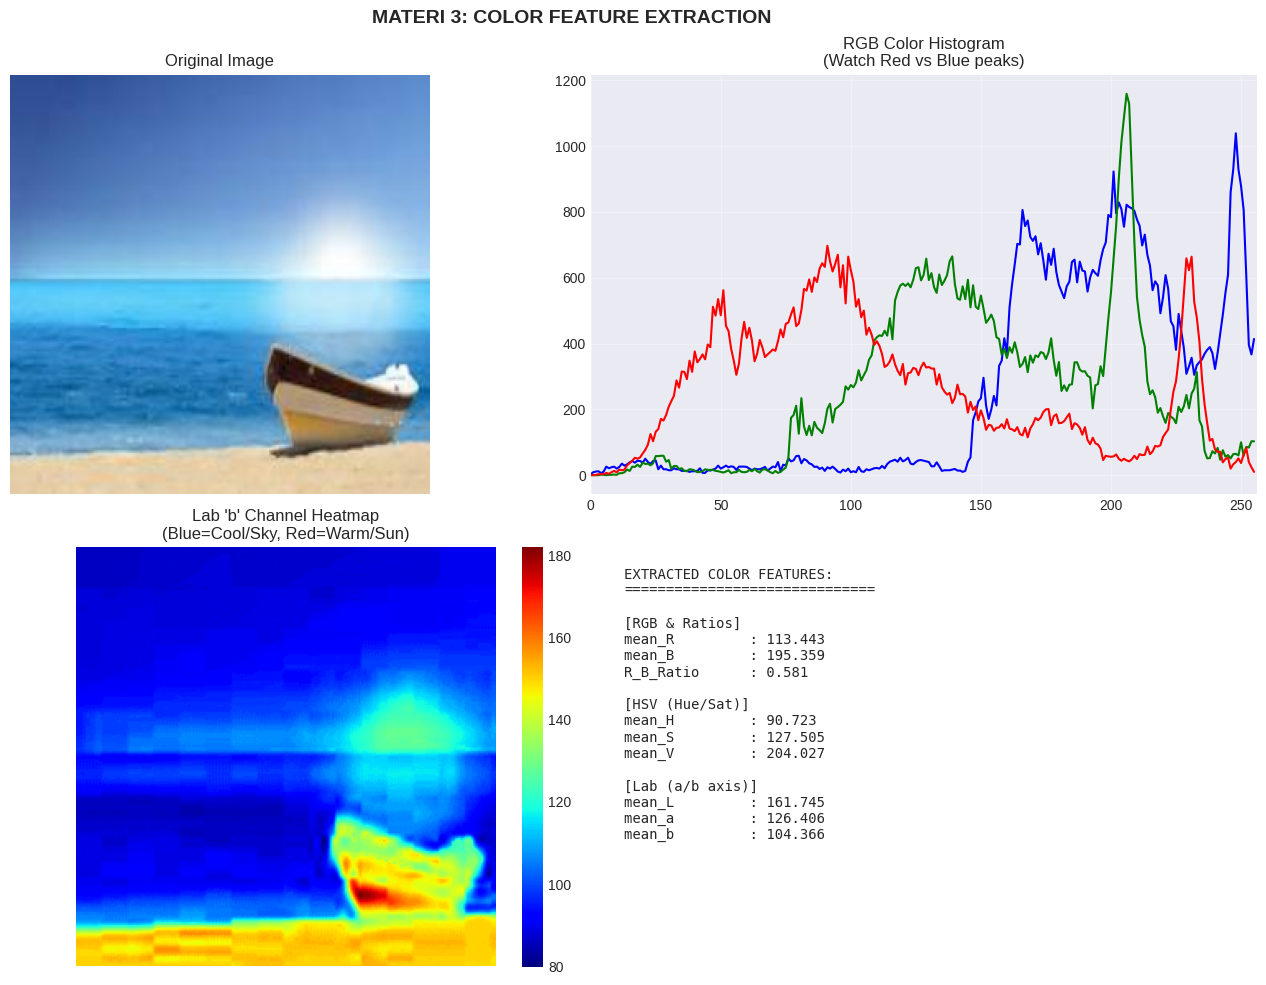

  Label Prediksi: Shine
[2] Menggunakan gambar: Sunrise/sunrise55.jpg


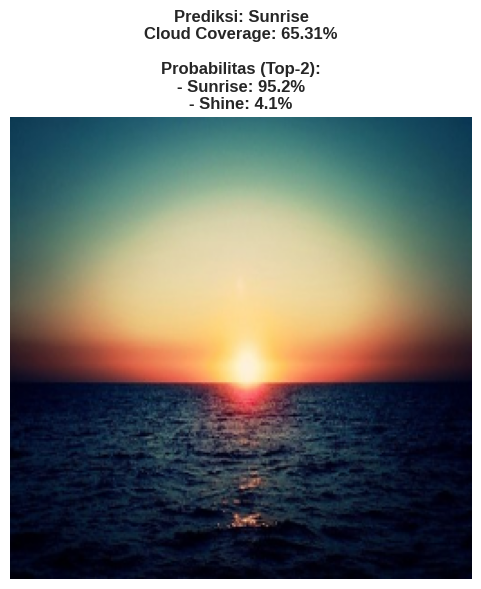

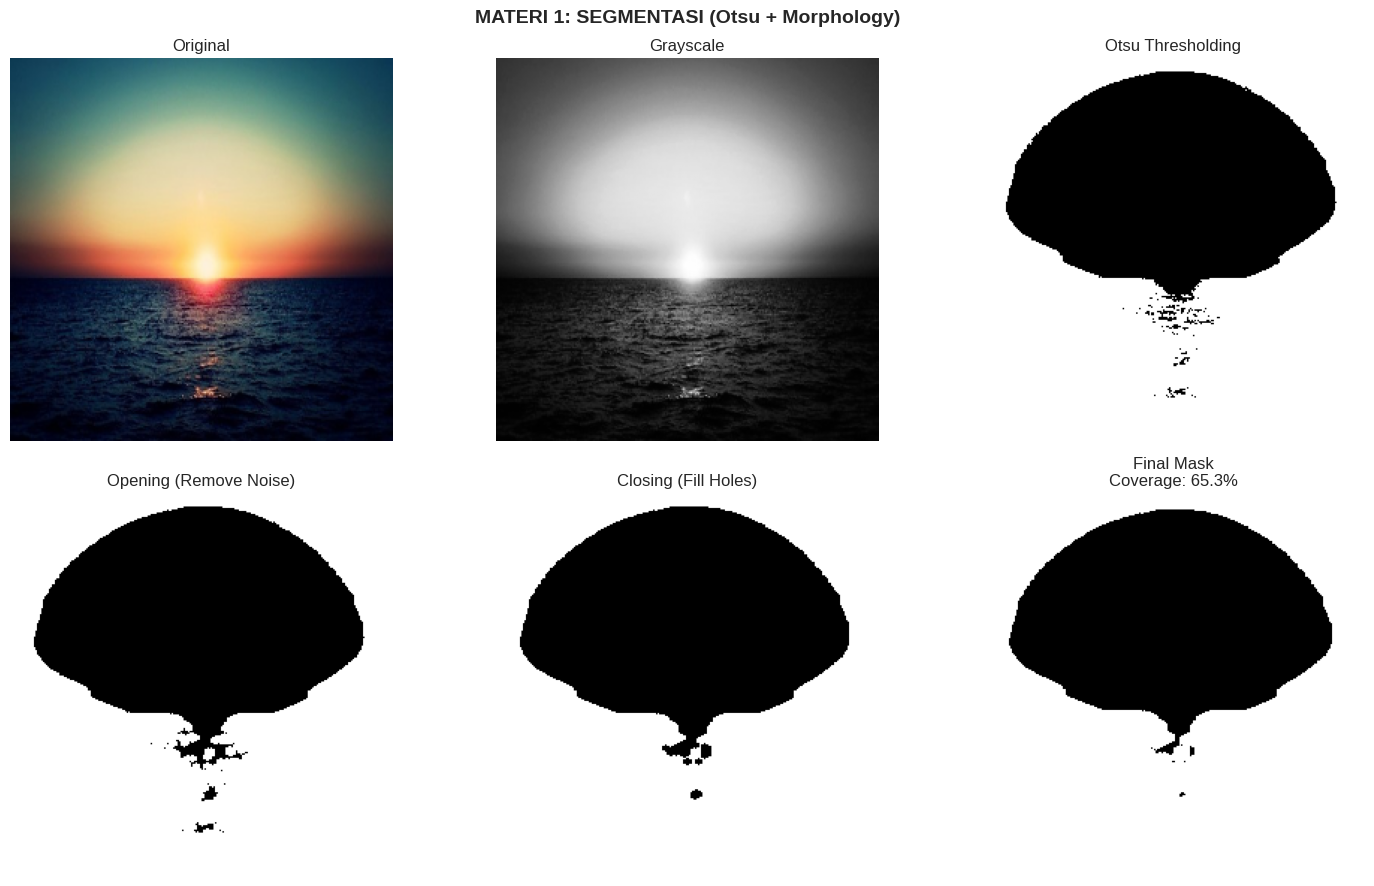

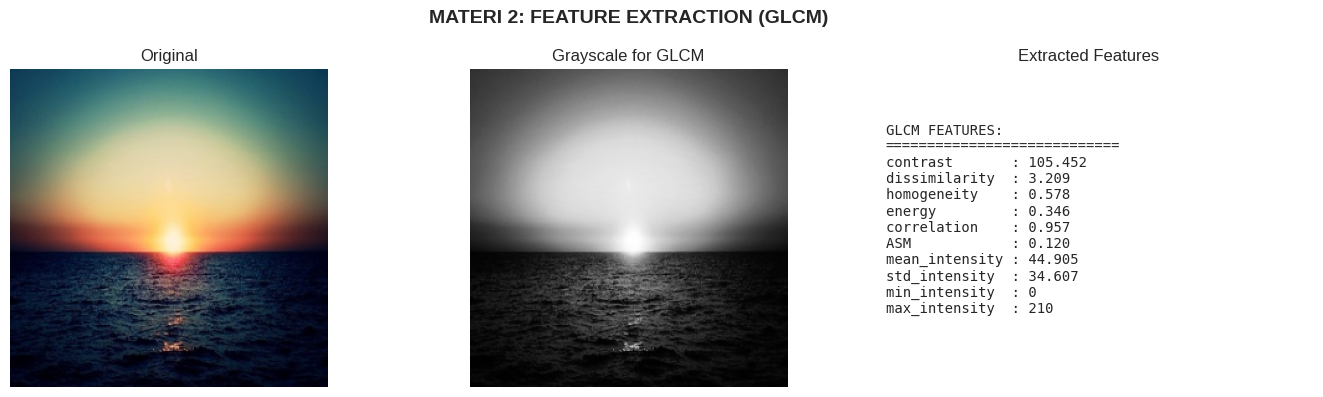

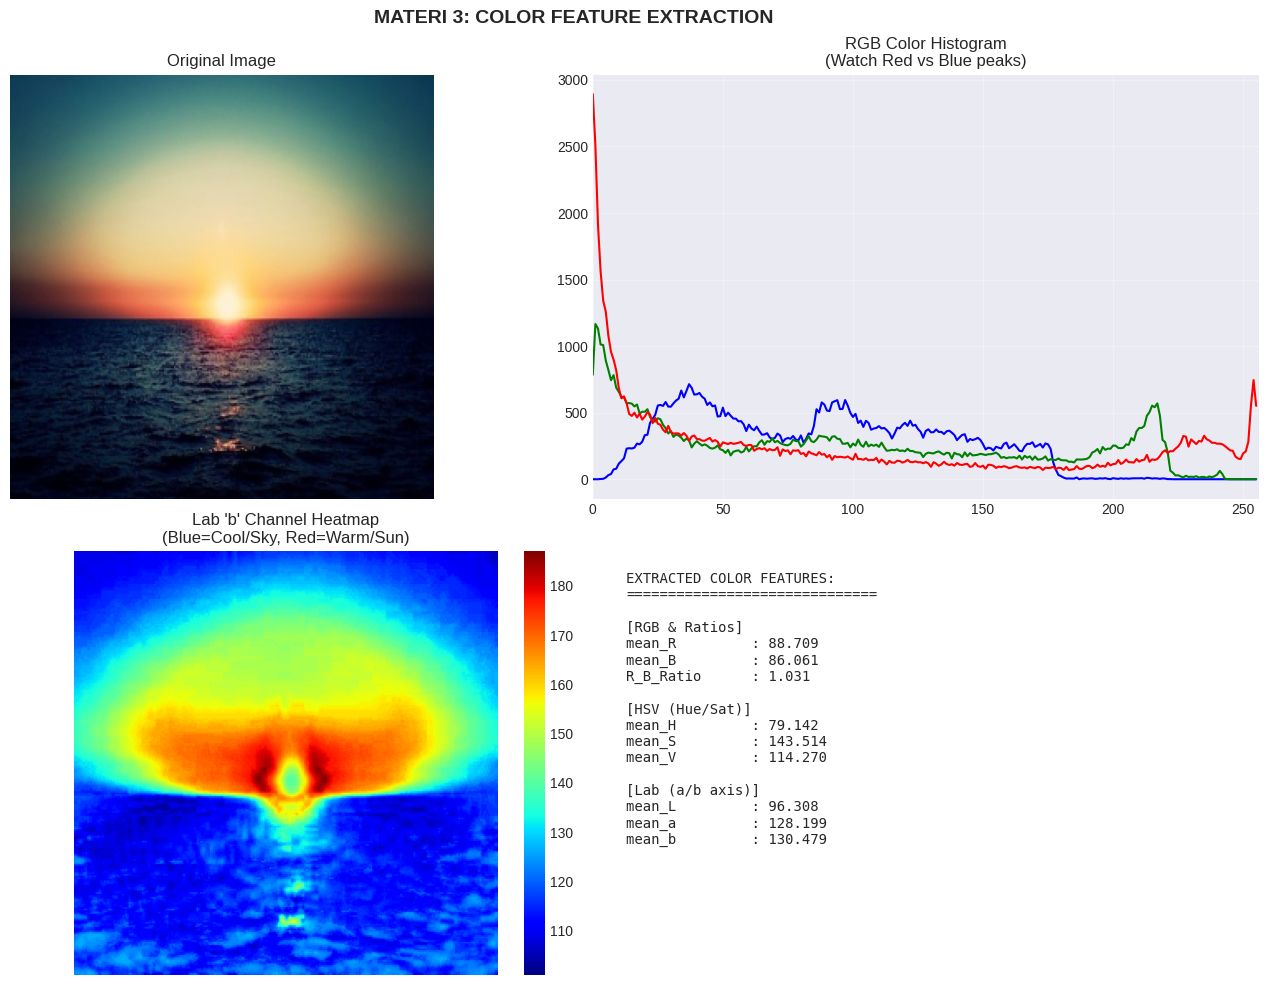

  Label Prediksi: Sunrise
[3] Menggunakan gambar: Rain/rain39.jpg


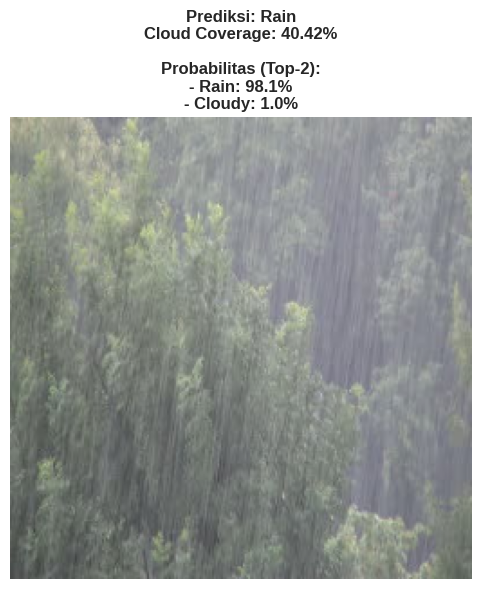

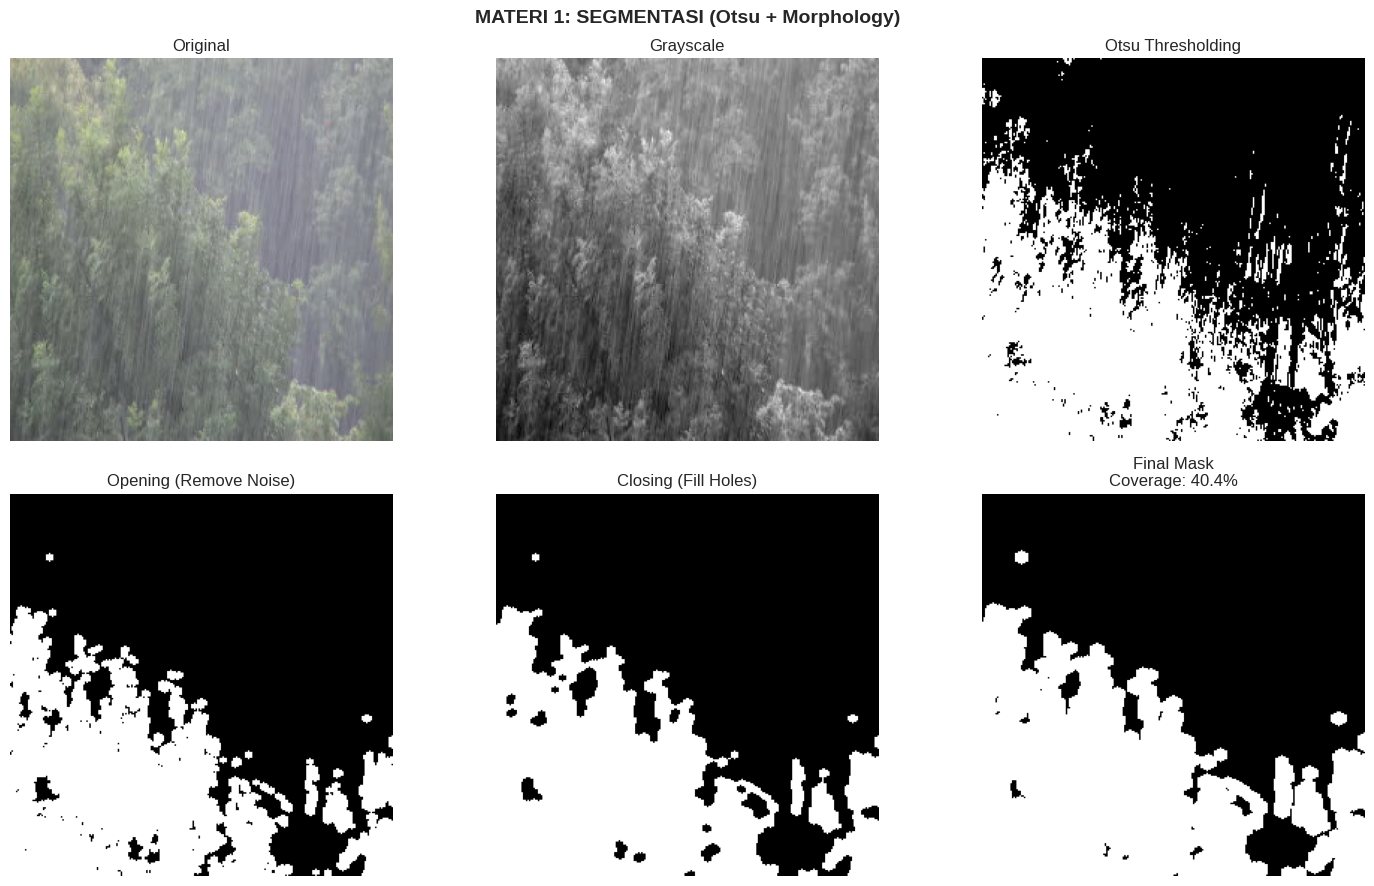

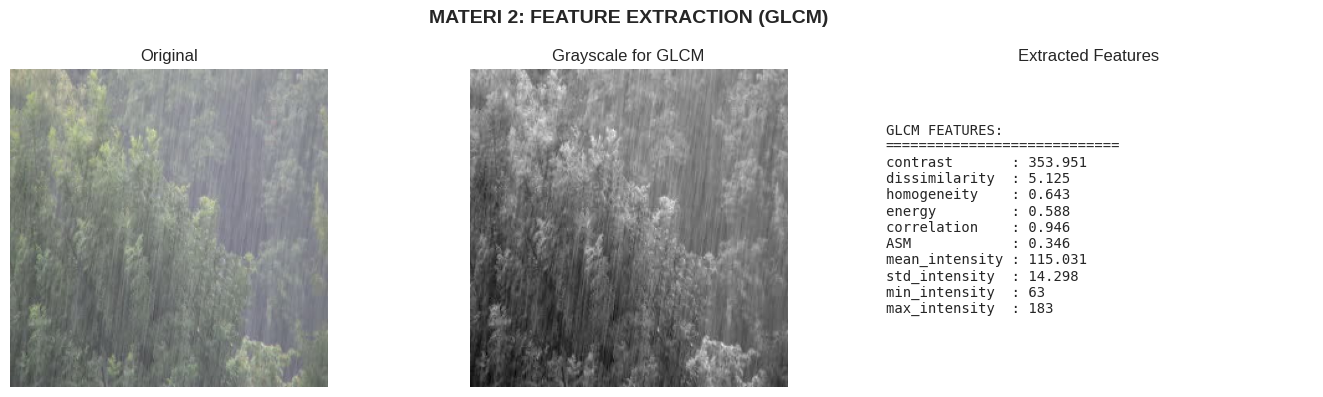

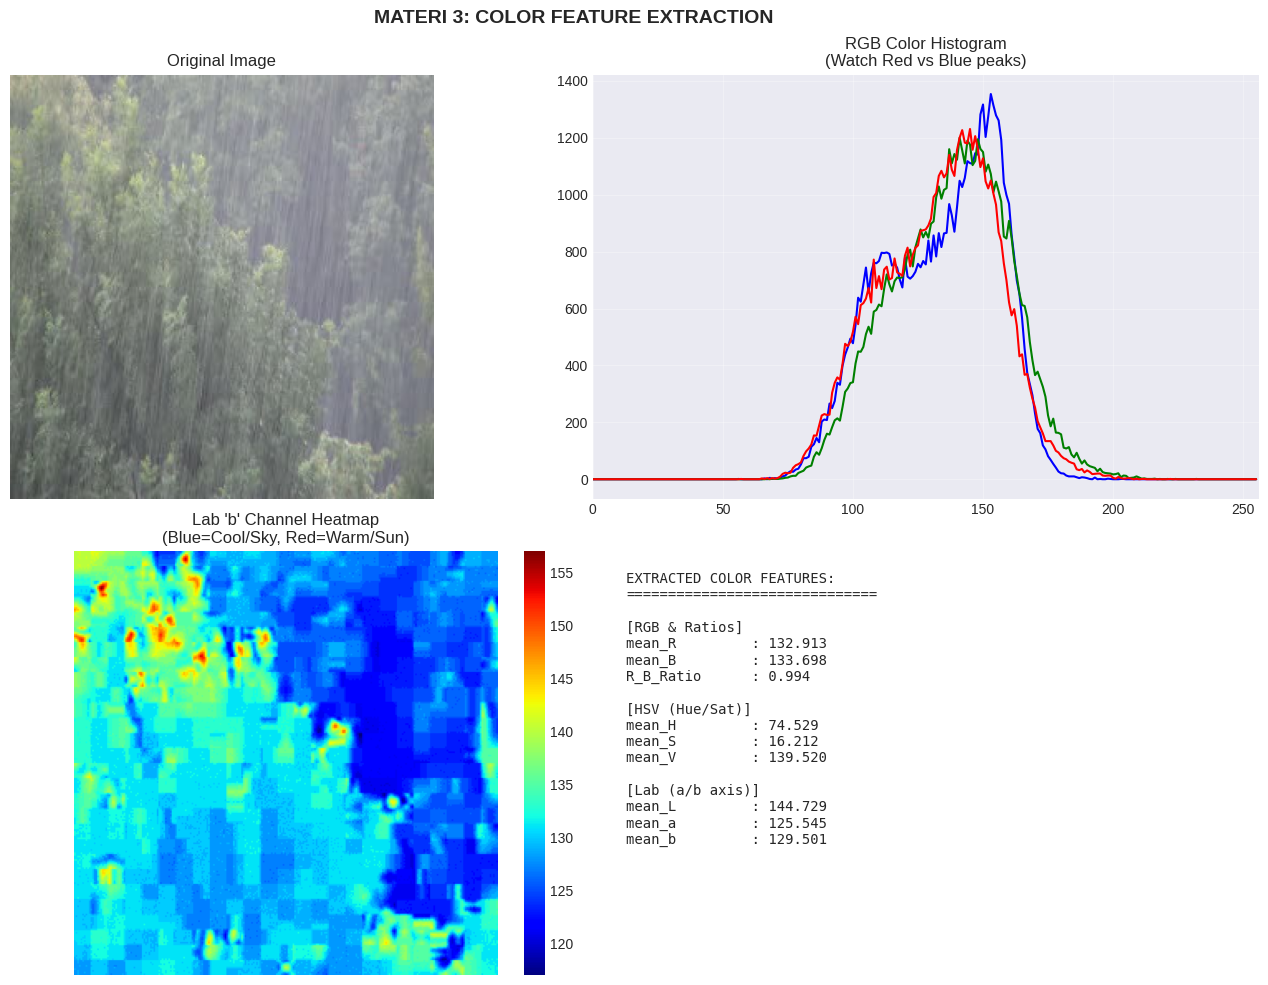

  Label Prediksi: Rain


In [ ]:
def pick_n_random_images(dataset_dir, n=3):
    categories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    all_images = []
    for cat in categories:
        folder = os.path.join(dataset_dir, cat)
        imgs = [os.path.join(folder, f) for f in os.listdir(folder)
                if f.lower().endswith(('.jpg','.jpeg','.png'))]
        all_images.extend(imgs)
    if len(all_images) < n:
        raise RuntimeError(f"Gambar kurang. Ditemukan {len(all_images)}, minta {n}.")
    return random.sample(all_images, n)

for i, img_path in enumerate(pick_n_random_images(DATASET_DIR, n=3), start=1):
    print(f"[{i}] Menggunakan gambar:", os.path.relpath(img_path, DATASET_DIR))
    save_prefix = f'predict_batch_{i}_'
    label_pred, _ = predict_image_with_visual(img_path, show_panels=True, save_prefix=save_prefix)
    print("  Label Prediksi:", label_pred)